## Otorowiri

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape

%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

modules = utils.list_modules(loopflopy)
for module in modules: print(module)

os.getcwd()

dem
disv2disu
flowmodel
flowmodel_routines
geomodel
geomodel_routines
mesh
mesh_routines
observations
project
spatial
spatial_routines
structuralmodel
surfacerefinement
utils


'c:\\Users\\00105010\\Projects\\Otorowiri\\scripts'

### 1. Setup Project

In [23]:
name = 'otorowiri'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe = '../exe/mfexe.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe)

### 2. Spatial Processing

POLYGON ((361337.20725018514 6735522.680110534, 361318.55532478204 6735525.34676506, 361300.2371096979 6735529.756794962, 361282.41518154956 6735535.871060632, 361265.24771234096 6735543.635297142, 361248.8870656651 6735552.98059585, 360589.151451948 6735972.229061367, 360574.4827576252 6735982.500582804, 359975.5522891828 6736443.188638042, 359972.66517840134 6736445.4518035585, 359627.74982986867 6736720.970266216, 359160.85397186875 6737035.591168093, 358646.0471174668 6737374.582637623, 358631.7419482652 6737384.935738192, 358618.4057506354 6737396.510296069, 358606.14248842536 6737409.21608047, 358595.04776129295 6737422.954042004, 358178.78923114884 6737987.677366506, 358168.802181669 6738002.582821196, 358160.19113841595 6738018.3233317, 357803.21527111484 6738746.661997532, 357802.45015107194 6738748.240553889, 357439.64677841234 6739505.1979318485, 356985.1587132632 6739946.094619135, 356649.4186185305 6740144.445396702, 355987.0582307656 6740394.382825348, 355969.0571409932 6

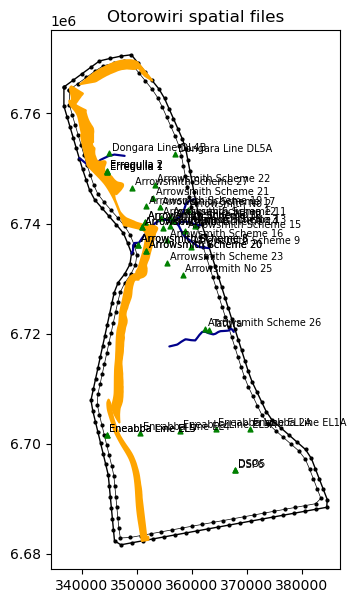

In [24]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = 28350)

import process_spatial
process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 800, node_spacing = 2000)
process_spatial.geo_bores(spatial)
process_spatial.obs_bores(spatial)
#process_spatial.obs_bores(spatial, observations)
process_spatial.pump_bores(spatial)
#process_spatial.head_boundary(spatial)
#process_spatial.faults(spatial)
process_spatial.river(spatial, node_spacing = 100, buffer_distance = 200, threshold = 100)
process_spatial.outcrop(spatial, node_spacing = 100, buffer_distance = 200, threshold = 100) 
#process_spatial.lakes(spatial)
#process_spatial.plot_spatial(spatial)
process_spatial.plot_spatial2(spatial, geobores = True, obsbores = False, pumpbores = False)

In [25]:
m = spatial.obsbore_gdf.explore()#location=[-31.4, 115.8], zoom_start=11, popup = 'ID')
#m = folium.Map(location=[52.0, 4.0], zoom_start=6) 
spatial.model_boundary_gdf.explore(m=m, fill = False)
#spatial.faults_gdf.explore(m=m, color = 'red')

### 3. Meshing

In [99]:
from loopflopy.mesh import Mesh
special_cells = {
    #'chd': ['west'], 
                 #'wel': ['pumpbores'], 
                 'obs': ['obsbores'], }
mesh = Mesh(plangrid = 'vor', special_cells = special_cells) # special cells to identify as arguements 

In [100]:
mesh.modelmaxtri = 400000
mesh.boundmaxtri = 999999999
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 200 # radius of inner circle around pumping bores
mesh.radius2 = 600 # radius of outer circle around pumping bores
mesh.boremaxtri = 99999999

mesh.create_bore_refinement(spatial)

node_list = []#'faults_nodes', 'bore_refinement_nodes']
polygon_list = ['model_boundary_poly', 'inner_boundary_poly']

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)

number of cells in plan =  4573


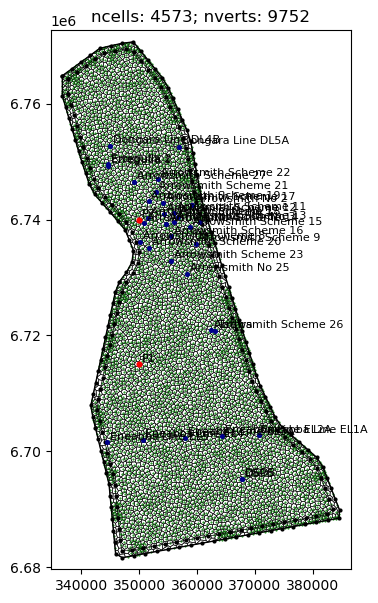

In [101]:
xlim = [spatial.x0 - 2000, spatial.x1 + 2000]
ylim = [spatial.y0 - 2000, spatial.y1 + 2000]

#xlim = [368000, 372000]
#ylim = [6512500, 6517500]

features = ['wel', 'obs']#, 'fault']
mesh.plot_cell2d(spatial, features, xlim, ylim)

### 4. Find Cell IDs of spatial features

Group =  obs ['obsbores']


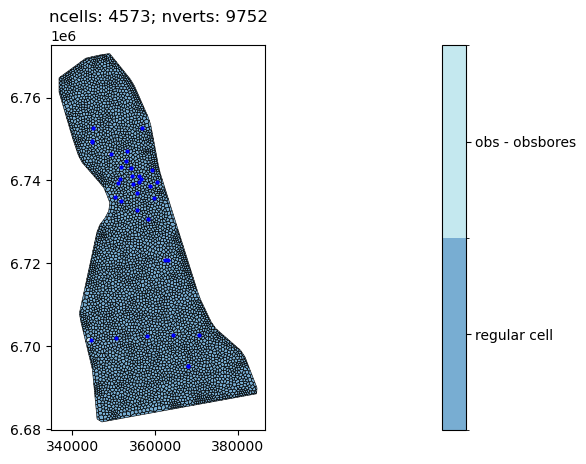

In [102]:
mesh.locate_special_cells(spatial)
mesh.plot_feature_cells(spatial, xlim, ylim)

### 5. Structural Model

In [9]:

# ------------------------------------------------------
geodata_fname = '../data/data_geology/bore_data.xlsx'
data_sheetname = 'geo'
strat_sheetname = 'strat'
bbox = [(330000, 6690000, -1000), (375000, 6750000, 300)] #[(x0, y0, z0), (x1, y1, z1)]
from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(spatial, bbox, geodata_fname, data_sheetname, strat_sheetname)

import process_structural
process_structural.prepare_strat_column(structuralmodel)
process_structural.prepare_geodata(structuralmodel, spatial, Fault = False)
process_structural.create_structuralmodel(structuralmodel, Fault = False)


1.6.1


c:\Users\00105010\Anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


In [10]:
structuralmodel.strat

,sequence,unit,R,G,B,val,lithid,Thickness,iconvert,hk,vk,ss,sy
0,Ground,Ground,255,255,255,232,-1,-,NaN,NaN,NaN,NaN,NaN
1,Yarragadee,Kp,172,186,242,124,0,108,1.0,10.0,10.0,0.00001,0.10
2,Yarragadee,Kpo,117,128,229,90,1,34,0.0,0.1,0.1,0.00001,0.01
3,Yarragadee,J,198,217,240,-1000,2,1090,0.0,10.0,10.0,0.00001,0.20


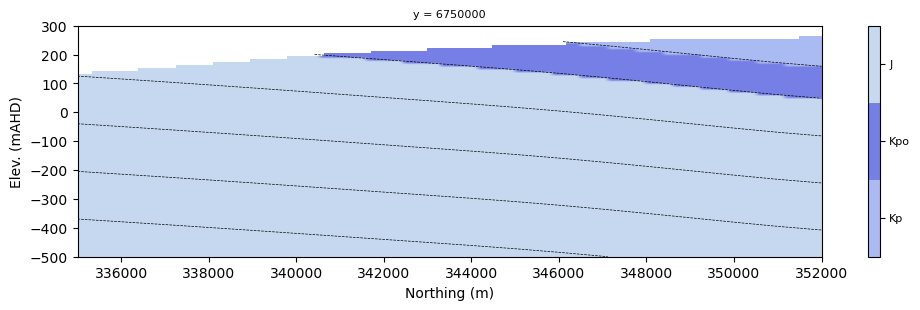

In [11]:
transect_x = [375000]#, 400000, 410000]
# DONGARA LINE - 6750000
# ENEABBA LINE - 6700000
transect_y = [6750000]# 6700000]
structuralmodel.faults=[]
#structuralmodel.plot_xtransects(transect_x, ny = 80, nz = 120)#, x1 = 6520000, z0 = -2000) 
#structuralmodel.plot_ytransects(transect_y, nx = 80, nz = 120, z0 = -1000) 
structuralmodel.plot_ytransects2(transect_y, nx = 80, nz = 80, x0 = 335000, x1 = 352000, z0 = -500, z1 = 300, dz = 50) 

### 6. Geomodel

In [12]:
# Set up Geomodel (lithological block model of cells)
scenario = 'example'
vertgrid = 'con'    # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}
z0, z1 = -500, 300 

from loopflopy.geomodel import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 2, res = 1) 

geomodel.evaluate_structuralmodel(mesh, structuralmodel)
geomodel.create_model_layers(mesh, structuralmodel)

geomodel.vgrid = flopy.discretization.VertexGrid(vertices=mesh.vertices, cell2d=mesh.cell2d, ncpl = mesh.ncpl, top = geomodel.top_geo, botm = geomodel.botm)

   0. Creating xyz array...
Time taken Block 0 (creating xyz array) =  3.573479
   1. Evaluating structural model...
len(xyz) =  3391200
Time taken Block 1 (Evaluate model) =  14.161097
   2. Creating geo model layers...
stop_array shape (4, 4239)
nlay =  800
ncpl =  4239
nlg number of geo layers =  3
ICPL =  0
line 225 stop  [799]
ICPL =  1
line 225 stop  [799]
ICPL =  2
line 225 stop  [799]
ICPL =  3
line 225 stop  [799]
ICPL =  4
line 225 stop  [799]
ICPL =  5
line 225 stop  [799]
ICPL =  6
line 225 stop  [799]
ICPL =  7
line 225 stop  [799]
ICPL =  8
line 225 stop  [799]
ICPL =  9
line 225 stop  [799]
ICPL =  10
line 225 stop  [799]
ICPL =  11
line 225 stop  [799]
ICPL =  12
line 225 stop  [799]
ICPL =  13
line 225 stop  [799]
ICPL =  14
line 225 stop  [799]
ICPL =  15
line 225 stop  [799]
ICPL =  16
line 225 stop  [799]
ICPL =  17
line 225 stop  [799]
ICPL =  18
line 225 stop  [799]
ICPL =  19
line 225 stop  [799]
ICPL =  20
line 225 stop  [799]
ICPL =  21
line 225 stop  [799]
ICP

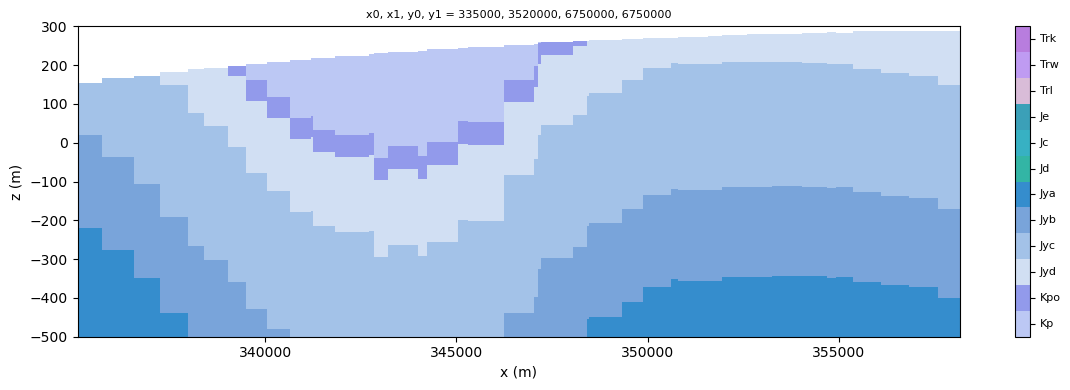

In [104]:
y0, y1 = 6750000, 6750000
geomodel.geomodel_transect_lith(structuralmodel, spatial, y0=y0, y1=y1, x0 = 335000, x1 = 3520000)# z0 = -200, z1 = 300


### 7. Assign hydrogeological parameters to cells

In [13]:
# FILL CELL PROPERTIES
props = pd.read_excel(structuralmodel.geodata_fname, sheet_name = 'strat')
props = props.drop(index=[0]).reset_index()#inplace=True) # drop first row as it is ground
geomodel.hk_perlay = props.hk.tolist()
geomodel.vk_perlay = props.vk.tolist()
geomodel.ss_perlay = props.ss.tolist()
geomodel.sy_perlay = props.sy.tolist()
geomodel.iconvert_perlay = props.iconvert.tolist()
geomodel.fill_cell_properties(mesh)
props

   6. Filling cell properties...
ang1 shape  (6, 4239)
21176
angle1 shape  (21176,)
Time taken Block 6 Fill cell properties =  0.017629


,index,sequence,unit,R,G,B,val,lithid,Thickness,iconvert,hk,vk,ss,sy
0,1,Yarragadee,Kp,172,186,242,124,0,108,1.0,10.0,10.0,0.00001,0.10
1,2,Yarragadee,Kpo,117,128,229,90,1,34,0.0,0.1,0.1,0.00001,0.01
2,3,Yarragadee,J,198,217,240,-1000,2,1090,0.0,10.0,10.0,0.00001,0.20


### 8. Prepare Data for Flowmodel

In [14]:
from process_data import Data
data = Data()

data.process_ic()#geomodel)
data.process_rch(geomodel, mesh)
#data.process_chd(spatial, geomodel, mesh)



### 9. Groundwater observations

In [ ]:
# First sorting out observation bores
#from process_observations import plot_hydrograph
import process_observations
df_boreids = process_observations.prefilter_data()
# plot_hydrograph(df_boreids, spatial)
# process_observations.plot_hydrograph(df_boreids, spatial)
df_boredetails = process_observations.assemble_clean_data(df_boreids)

from loopflopy.observations import Observations
#observations = Observations(df_boredetails)
#df_boredetails, df_obs = process_observations.add_WL_obs(df_boredetails)

ImportError: cannot import name 'plot_hydrograph' from 'process_observations' (c:\Users\00105010\Projects\Otorowiri\scripts\process_observations.py)

In [21]:
parmelia_boreids = df_boreids['Site Short Name'].unique()
print('Parmelia boreids: ', parmelia_boreids)

Parmelia boreids:  ['Pugh 3' 'El1C' 'El2B' 'El3B' 'El3C' 'El4A' 'WNR1C' 'WNR2A' 'WNR2B'
 'WNR2C' 'WNR2D' 'WNR3A' 'WNR3B' 'WNR3C' 'AR1' 'AR6(ART)' 'AR7' 'AR9'
 'AR10(ART)' 'AR11' 'AR12(ART)' 'AR13' 'AR14' 'AR15' 'AR16' 'AR17' 'AR18'
 'AR20' 'AR21' 'AR22' 'AR23' 'AR26' 'AR27' 'AR8' 'AR19' 'No.2' 'DL5W']


### 10. Create and run steady-state flow model

In [16]:
from loopflopy.flowmodel import Flowmodel
scenario = 'steadymodel'

fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)
utils.print_object_details(fm)


Methods:
get_watertable
plot_plan
plot_transect
plot_watertable
run_flowmodel
write_flowmodel

Variables
data
geomodel
lith
logk11
logk33
mesh
newtonoptions
observations
project
scenario
staggered
xt3d


In [17]:
# Write and run flow model files
sim = fm.write_flowmodel(chd = False, wel = False, obs = False, rch = True)
fm.run_flowmodel(sim)

   Writing simulation and gwf for  steadymodel  ...
   Time taken to write flow model =  9.22015
Running simulation for  steadymodel  ...


FileNotFoundError: The program ../exe/mfexe.exe does not exist or is not executable.

In [ ]:
# Write and run flow model files
sim = fm.write_flowmodel(chd = True, wel = True, obs = True, rch = True)
fm.run_flowmodel(sim)

In [ ]:
watertable = fm.get_watertable(geomodel, fm.head)
fm.plot_watertable(spatial, mesh, geomodel, fm, watertable, vmin = -10, vmax = 150)#, extent, vmin, vmax

In [ ]:
fm.plot_transect(spatial, structuralmodel, array = 'head',  
                 z0 = -1000, z1 = 400, y0 = spatial.y1-5, y1 = spatial.y1-5, x0 = 370000, x1 = 380000)#y0 = 6530000, y1 = 6530000)#, X0, X1, Y0, Y1)

### 11. Create and run transient flow model

In [ ]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fmss.head
flowmodel = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
flowmodel.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

In [ ]:
sim = flowmodel.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True)

In [ ]:
flowmodel.run_flowmodel(sim, transient = True)

In [ ]:
watertable = flowmodel.get_watertable(geomodel, flowmodel.head)

### 12. Visualise Results

In [ ]:
import plotting_routines

vmin, vmax = 495, 505 #min(flowmodel.head.flatten()), max(flowmodel.head.flatten())
extent = [spatial.x0, spatial.x1, spatial.y0, spatial.y1]
X0, X1, Y0, Y1 = spatial.x0, spatial.x1, 7440000, 7440000
plotting_routines.plot_watertable(spatial, mesh, geomodel, flowmodel, watertable, extent = extent)#, vmin=vmin, vmax=vmax)
plotting_routines.plot_transect(spatial, flowmodel, array, X0, X1, Y0, Y1)#, vmin, vmax)

# PLOT BY LAYER
#from plotting_routines import plot_plan
#array = 'head'
#layer = 0
#plot_plan(spatial, mesh, flowmodel, array, layer, extent = extent, vmin=vmin, vmax=vmax, vectors = True)

### 13. Forecasting

In [ ]:

class Forecast:
    def __init__(self, name):
        self.name = name

forecast = Forecast('forecast_scenario_1')
forecast.qwell = [-200000, -200000] #m3/d 


In [ ]:
scrap code

# FOR TRANSIENT
rch_list = []
for index, row in df.iterrows(): 
    for i in range(4,16): # Jan-Dec
        rch_list.append(row.iloc[i]/1000) # mm to m

nper = len(rch_list)
ncpl = len(cell2d)

# FOR HFB IF WE USE

# import disv2disu # MODFLOW Tools
# Disv2Disu = disv2disu.Disv2Disu    
# nlay = 1
# botm = np.zeros_like(top).reshape(1, len(cell2d))
# idomain = np.ones_like(top).reshape(1, len(cell2d))
# dv2d = Disv2Disu(vertices, cell2d, top, botm, staggered=False, disv_idomain = idomain)
# dv2d._neighbors
# #dv2d._edge_set
# 
# dyke_K, dyke_width = 0.0001, 2  
# hydchr = dyke_K / dyke_width  
# 
# # Set up Horizontal Flow Barrier (HFB)
# for n in range(gdf.shape[0]): # For each dyke...
#     # Vertical
#     for lay in range(nlay):
#         for cell ibd[cell]
#         if zc[lay, icpl] < dyke_top[n]: 
#             hfb.append(([lay, cellid_1], [k, cellid_2], hydchr))

#### FAULT
#P.fault_buffer = 800

# Import fault shape file
#bada_shp = gpd.read_file('../data/shp/badaminna_trace.shp')
#bada_shp.to_crs(epsg=28350, inplace=True)
#bada_shp = gpd.clip(bada_shp, model_boundary)

#from meshing_routines import prepare_fault_nodes_voronoi
#fault_refinement_nodes = prepare_fault_nodes_voronoi(P, '../data/shp/badaminna_trace.shp', model_boundary, inner_boundary)

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation


def data_gen():
    for cnt in itertools.count():
        t = cnt / 10
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 1)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

# Only save last 100 frames, but run forever
ani = animation.FuncAnimation(fig, run, data_gen, interval=100, init_func=init,
                              save_count=100)
plt.show()

In [ ]:
# METHOD BARDOT 2024
from meshing_routines import resample_linestring
import itertools
from datetime import datetime

t0 = datetime.now()

def voronoi_nodes_gdf(gdf, refinement_boundary_poly, buffer):

    dyke = []
    hfb_1, hfb_2 = [], []
    nodes = []
    
    for n in range(gdf.shape[0]): 
        
        # Dykes notes (on the dyke linestring)
        linestring = dykes_gdf.geometry[n]
        r = 2*buffer/3 # distance between points
        ls_resample = resample_linestring(linestring, r) # resample orginal dyke line
        dyke.append(ls_resample)
        
        # Refinement nodes
        offsets = [-1.5*r, -0.5*r, 0.5*r, 1.5*r]
        fault_offset_lines = []
        for i, offset in enumerate(offsets):
            ls = linestring.parallel_offset(offset) # linestring.parallel_offset
            ls_resample = resample_linestring(ls, r)
            
            p = []
            for point in ls_resample:
                x,y = point.x, point.y
                p.append((x,y))
                #if refinement_boundary_poly.contains(point):
                #    x,y = point.x, point.y
                #    p.append((x,y))
            
            if len(p) != 1: # just incase there is a 1 point linestring
                offset_ls = LineString(p)
                coords = list(offset_ls.coords)
                fault_offset_lines.append(coords) 
                if i == 1: # SIDE 1
                    hfb_1.append(coords)
                if i == 2: # SIDE 2
                    hfb_2.append(coords)
                
        nodes.append([tup for line in fault_offset_lines for tup in line]) 
    refinement_nodes = list(itertools.chain.from_iterable(nodes))

    return(refinement_nodes, hfb_1, hfb_2)

# Import dykes shape file
dykes_gdf = gpd.read_file('../data_shp/dykes_m.shp')
dykes_gdf.to_crs(epsg=28350, inplace=True)
dykes_gdf = gpd.clip(dykes_gdf, inner_boundary_poly).reset_index(drop=True)
#dykes_gdf.plot()

dyke_nodes, hfb_1, hfb_2 = voronoi_nodes_gdf(dykes_gdf, refinement_boundary_poly, buffer)

t1 = datetime.now()
print(t1 - t0) 

In [ ]:

from sklearn.cluster import DBSCAN
from alphashape import alphashape

def create_surfacegeo_polys(geomodel, lith):
    points = []
    a = np.array(mesh.cell2d)
    b = a[geomodel.surf_lith==lith]
    verts = np.unique(b[:,4:7].flatten())
    verts = [int(x) for x in verts]
    vert_coords = []
    for v in verts:
        vert_coords.append(mesh.vertices[v][1:3])
    xlist, ylist = list(zip(*vert_coords))
    gdf = gpd.GeoDataFrame(pd.DataFrame({'x': xlist, 'y': ylist}), 
                           geometry = gpd.points_from_xy(x = xlist, y = ylist))
    # Extract coordinates for clustering
    coords = gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
   # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=5000, min_samples=3)  # eps: max distance for clustering
    gdf['cluster'] = dbscan.fit_predict(coords)
    
    # Create concave hulls for each cluster
    hulls = []
    for cluster_id in gdf['cluster'].unique():
        
        if cluster_id != -1:  # Exclude noise points
            cluster_points = gdf[gdf['cluster'] == cluster_id]
            print('\ncluster id = ', cluster_id, ', number of points = ', len(cluster_points))
            points_list = cluster_points.geometry.apply(lambda p: (p.x, p.y)).tolist()
            
            # CONCAVE
            mp = MultiPoint(points_list)
            gs = gpd.GeoSeries(mp)
            hull = gs.concave_hull(ratio = 0.2, allow_holes = False)
            hulls.append(hull)
    
    hull_gdf = gpd.GeoDataFrame(pd.concat(hulls, ignore_index=True), columns=['geometry'])
    return (gdf, hull_gdf)

def plot_geology_polygons(gdf, hull_gdf):
    # Plot results
    fig, ax = plt.subplots()
    gdf.plot(ax=ax, color='blue', markersize=3, label='Points')
    hull_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label='Concave Hulls')
    plt.legend()
    plt.show()

for i in range(7):
    gdf, hull_gdf = create_surfacegeo_polys(geomodel, i)
    plot_geology_polygons(gdf, hull_gdf)

In [ ]:
print(structuralmodel.model.bounding_box.nsteps)
structuralmodel.model.bounding_box.nelements = 1e6
print(structuralmodel.model.bounding_box.nsteps)

# Extract surfaces
surfaces = structuralmodel.model.get_stratigraphic_surfaces()

# Interpolate onto a structured grid
from LoopStructural.interpolators.supports import P1Unstructured2d, StructuredGrid2D
loopmesh = P1Unstructured2d(surfaces[0].triangles, surfaces[0].vertices[:, 0:2], surfaces[0].triangles[:, 0:3]) # Ground is surfaces [0] (ELEMENTS, VERTICES, NEIGHBOURS)
# loopmesh
#dx, dy = 1000, 1000 # 1000m cells
#nx = int((structuralmodel.x1 - structuralmodel.x0)/dx)
#ny = int((structuralmodel.y1 - structuralmodel.y0)/dy)
#structured2d = StructuredGrid2D(origin=[structuralmodel.x0, structuralmodel.y0], nsteps=[nx, ny], step_vector= [dx, dy])
pts = mesh.xcyc  #structured2d.barycentre # replace with my xcyc
z = loopmesh.evaluate_value(pts, surfaces[0].vertices[:, 2])
np.unique(z)
## we expect the values to be close to zero depending on the resultion of the interpolation
#geomodel["Ground"].evaluate_value(np.hstack([pts, z[:, np.newaxis]]))

surface = structuralmodel.model['Ground'].surfaces([0])[0]
#surfaces = structuralmodel.model.get_stratigraphic_surfaces(units = ['Ground'])
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()
for s in surfaces:
    p.add_mesh(s.vtk())
p.add_points(surface.vertices)
#p.add_mesh(surfaces[0].vtk)
p.show()

from LoopStructural.visualisation import Loop3DView
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=geomodel.vgrid)
arr = pmv.plot_array(geomodel.idomain[0], alpha = 0.6) #(M.botm_geo[0], alpha = 0.6)
mesh.tri.plot(ax=ax, edgecolor='black', lw = 0.1)
cbar = fig.colorbar(arr, ax=ax, shrink = 0.5)  